In [1]:
import math

import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
reviews = pd.read_csv('Reviews.csv')

In [3]:
# Rating function for a review. Biased towards reviews with more total views. 
#   E.g. 1 positive view out of 1 total view will not rate as high as 
#        1000 positive views out of 1200 total views.
#[CITE] https://www.evanmiller.org/how-not-to-sort-by-average-rating.html
def lbc(posVote, totalVote):
    #Total vote to reduce calculation
    negVote = totalVote - posVote
    #Return zero if no votes o
    if(totalVote == 0):
        return 0.0
    magic = ((posVote + 1.9208) / (totalVote) - 1.96 * math.sqrt((posVote * negVote) / (totalVote) + 0.9604) / 
                (totalVote)) / (1 + 3.8416 / (totalVote))
    return magic

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# [CITE] https://codedump.io/share/w8TDdH1LYgGt/1/format-certain-floating-dataframe-columns-into-percentage-in-pandas
nullPercents = reviews.isnull().sum()/reviews.count()
nullPercents.sort_values(inplace=True,ascending=False)
nullPercents = pd.Series([str(round(val*100, 2))+"%" for val in nullPercents], index = nullPercents.index)
nullPercents

Summary                   0.0%
ProfileName               0.0%
Text                      0.0%
Time                      0.0%
Score                     0.0%
HelpfulnessDenominator    0.0%
HelpfulnessNumerator      0.0%
UserId                    0.0%
ProductId                 0.0%
Id                        0.0%
dtype: object

In [6]:
#Remove 2 rows where numerator > denominator. Assume this is entry error in dataset
reviews = reviews.drop(reviews[reviews['HelpfulnessNumerator'] > reviews['HelpfulnessDenominator']].index)

In [7]:
#Create column associated with a review that contains the lbc value for that row
reviews['Lbc'] = reviews.apply(lambda row: lbc(row['HelpfulnessNumerator'], row['HelpfulnessDenominator']), axis=1)

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568452 entries, 0 to 568453
Data columns (total 11 columns):
Id                        568452 non-null int64
ProductId                 568452 non-null object
UserId                    568452 non-null object
ProfileName               568436 non-null object
HelpfulnessNumerator      568452 non-null int64
HelpfulnessDenominator    568452 non-null int64
Score                     568452 non-null int64
Time                      568452 non-null int64
Summary                   568426 non-null object
Text                      568452 non-null object
Lbc                       568452 non-null float64
dtypes: float64(1), int64(5), object(5)
memory usage: 52.0+ MB


In [9]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#Make matplotlib pretty
matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

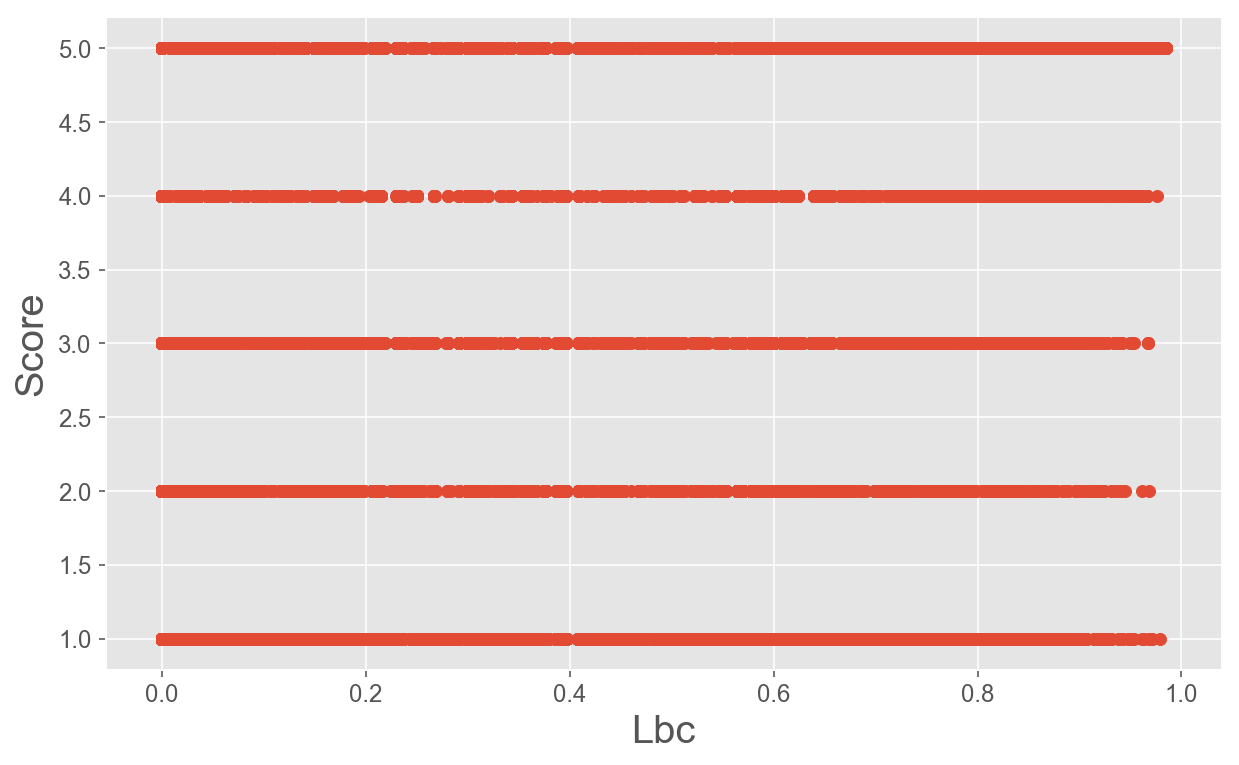

In [10]:
plt.scatter(reviews['Lbc'], reviews['Score'])
plt.xlabel('Lbc')
plt.ylabel('Score')
plt.show()

In [11]:
dfScoreGroup = reviews.sample(frac=.05).groupby(['Score'])

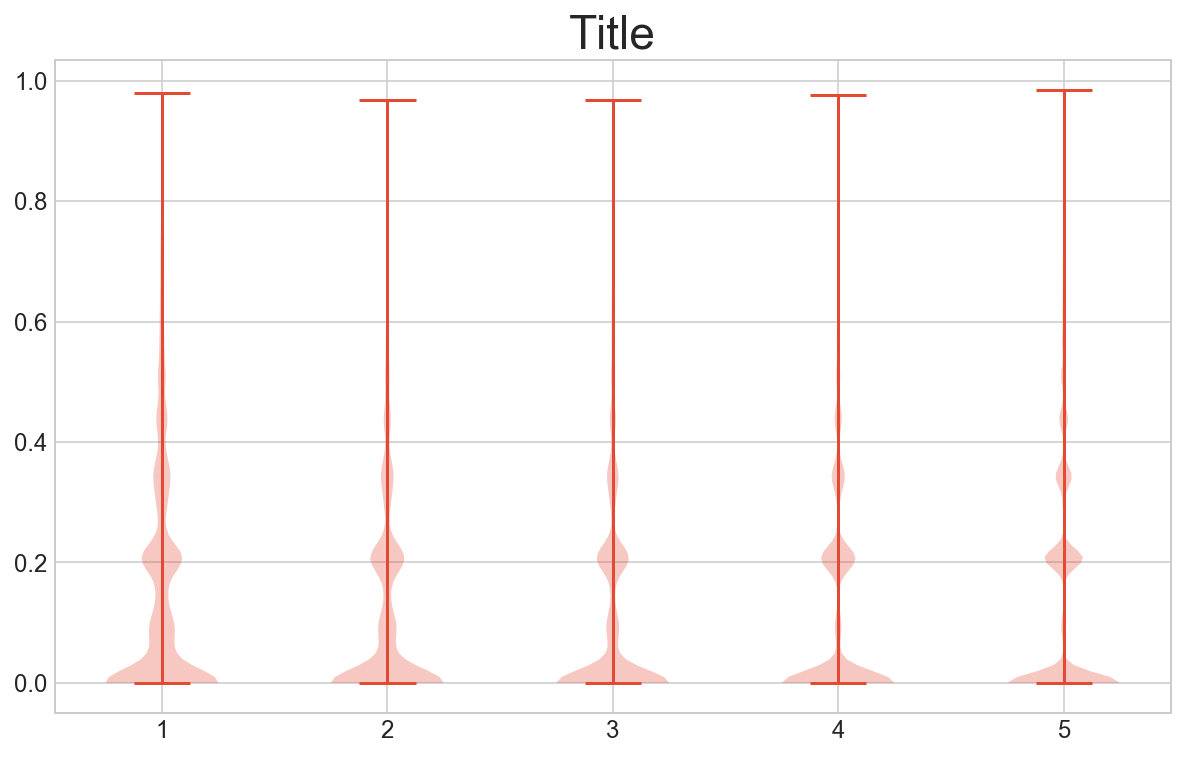

In [17]:
#Graph of lbc grouped by score
# fig, axes = plt.subplots(ncols=5, figsize=(20,  15))
# dfScoreGroup.boxplot(column=['Lbc'], ax=axes)
# plt.yscale('symlog')
# plt.show()

# [CITE] https://stackoverflow.com/a/43346806/3592716
sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=[
    reviews[reviews.Score == 1]['Lbc'],
    reviews[reviews.Score == 2].Lbc,
    reviews[reviews.Score == 3].Lbc,
    reviews[reviews.Score == 4].Lbc,
    reviews[reviews.Score == 5].Lbc
])
axes.set_title('Title')
plt.show()

In [19]:
scoreGroupSkewed = reviews[reviews['HelpfulnessDenominator'] != 0]

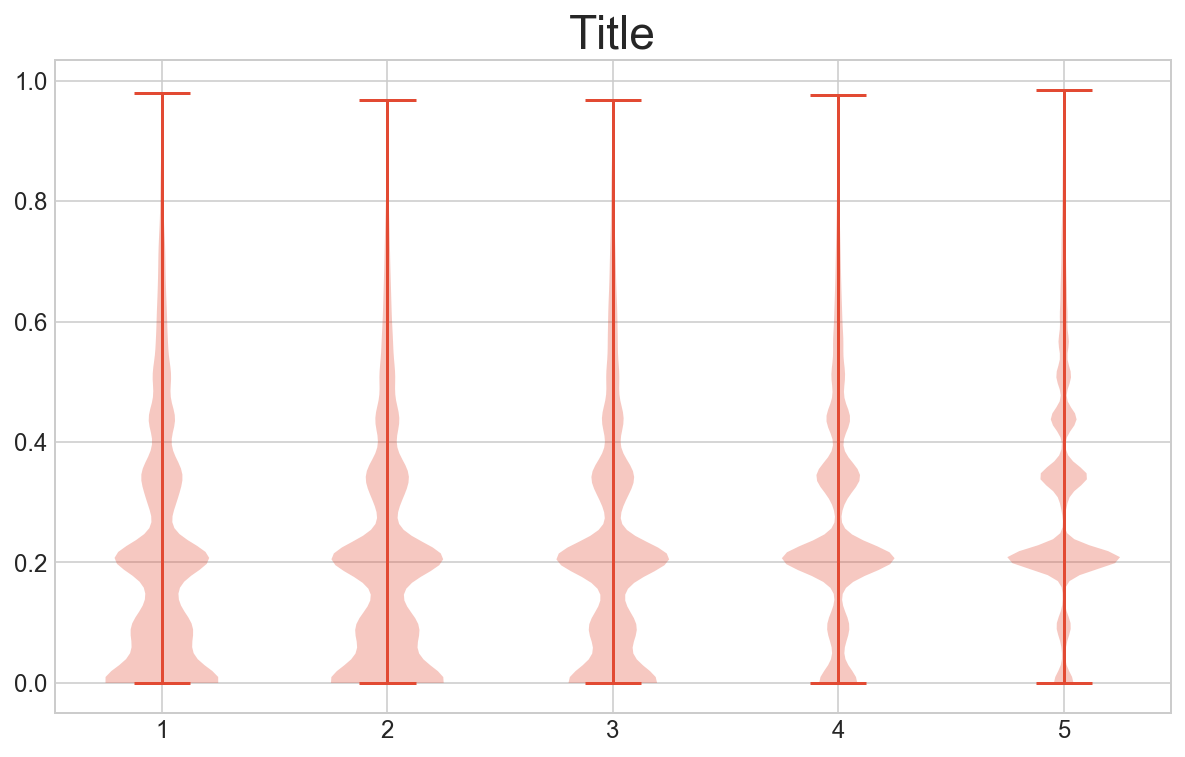

In [21]:
#As the rating the author goes up, the usefulness of the comment get better
sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=[
    scoreGroupSkewed[scoreGroupSkewed.Score == 1]['Lbc'],
    scoreGroupSkewed[scoreGroupSkewed.Score == 2].Lbc,
    scoreGroupSkewed[scoreGroupSkewed.Score == 3].Lbc,
    scoreGroupSkewed[scoreGroupSkewed.Score == 4].Lbc,
    scoreGroupSkewed[scoreGroupSkewed.Score == 5].Lbc
])
axes.set_title('Title')
plt.show()